### Data Dictionary

The goal of this exercise is to do Model Development and Validation to find the answer to the Question 4 of the problem statement:

Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1?

Using the best model, you need to predict the number of future complaints (of the Complaint Type that you decided to focus on in Question 1).

### Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer
from feature_engine import outlier_removers as outr

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump, load

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

### Data Exploration

In [32]:
df = pd.read_csv("queensclasstrain.csv", nrows=40000)

In [33]:
df

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,ComplaintType
0,1760.0,39.0,0.61,2.0,5.0,9580.0,100.00,1.0,2.0,1680.0,1600.0,1.80,1500.0,71.0,85.0,0
1,1760.0,39.0,0.61,2.0,5.0,9580.0,100.00,1.0,2.0,1680.0,1600.0,1.80,1500.0,71.0,85.0,4
2,5569.0,94.0,2.16,2.0,5.0,9580.0,100.00,1.0,4.0,1680.0,1600.0,1.80,1500.0,0.0,9.0,3
3,1760.0,39.0,0.61,2.0,5.0,9580.0,100.00,1.0,2.0,1680.0,1600.0,1.80,1500.0,71.0,85.0,1
4,1760.0,39.0,0.61,2.0,5.0,9580.0,100.00,1.0,2.0,1680.0,1600.0,1.80,1500.0,71.0,85.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,2353.0,66.0,0.75,2.0,2.0,3141.0,100.00,2.0,2.0,1680.0,2353.0,1.25,1500.0,91.0,105.0,3
39996,1056.0,26.0,0.34,2.0,2.0,3131.0,100.00,2.0,2.0,1680.0,1056.0,1.25,1500.0,91.0,105.0,0
39997,1072.0,26.0,0.41,2.0,2.0,2628.0,97.33,2.0,2.0,1680.0,1072.0,1.25,1500.0,91.0,105.0,0
39998,1072.0,26.0,0.41,2.0,2.0,2596.0,97.33,2.0,2.0,1680.0,1072.0,1.25,1500.0,91.0,105.0,0


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   BldgArea       40000 non-null  float64
 1   BldgDepth      40000 non-null  float64
 2   BuiltFAR       40000 non-null  float64
 3   CommFAR        40000 non-null  float64
 4   FacilFAR       40000 non-null  float64
 5   LotArea        40000 non-null  float64
 6   LotDepth       40000 non-null  float64
 7   NumBldgs       40000 non-null  float64
 8   NumFloors      40000 non-null  float64
 9   OfficeArea     40000 non-null  float64
 10  ResArea        40000 non-null  float64
 11  ResidFAR       40000 non-null  float64
 12  RetailArea     40000 non-null  float64
 13  Age            40000 non-null  float64
 14  Period         40000 non-null  float64
 15  ComplaintType  40000 non-null  int64  
dtypes: float64(15), int64(1)
memory usage: 4.9 MB


In [35]:
df.describe(include='all')

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,ComplaintType
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,2742.256975,50.736234,1.104146,1.965050,2.284540,3062.694750,94.854178,1.271150,2.315512,1660.082075,2187.329575,1.251793,1482.127225,66.344350,80.817700,1.252675
std,1424.077317,18.464602,0.517041,0.183655,0.851296,2126.826047,12.899366,0.508512,0.734864,132.735223,1043.665337,0.390735,102.375337,23.628072,23.467777,1.329445
min,25.000000,1.000000,0.010000,1.000000,1.000000,1.000000,0.390000,1.000000,1.000000,25.000000,299.000000,0.500000,132.000000,-55.000000,3.000000,0.000000
25%,1728.000000,37.000000,0.710000,2.000000,2.000000,2000.000000,98.867500,1.000000,2.000000,1680.000000,1512.000000,0.900000,1500.000000,56.000000,70.000000,0.000000
50%,2260.000000,47.000000,0.970000,2.000000,2.000000,2400.000000,100.000000,1.000000,2.000000,1680.000000,1792.000000,1.250000,1500.000000,72.000000,89.000000,1.000000
75%,3414.000000,58.000000,1.400000,2.000000,2.000000,2910.000000,100.000000,2.000000,3.000000,1680.000000,2622.000000,1.800000,1500.000000,81.000000,95.000000,2.000000
max,5569.000000,94.000000,2.160000,2.000000,5.000000,9580.000000,100.000000,5.000000,4.000000,1680.000000,4584.000000,1.800000,1500.000000,156.000000,170.000000,4.000000


In [36]:
df.shape

(40000, 16)

In [37]:
df.columns

Index(['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'LotArea',
       'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea',
       'ResidFAR', 'RetailArea', 'Age', 'Period', 'ComplaintType'],
      dtype='object')

In [38]:
df['ComplaintType'].value_counts()

0    14995
1    12444
3     4471
2     4055
4     4035
Name: ComplaintType, dtype: int64

### Data Visualization

### Univariate Data Exploration

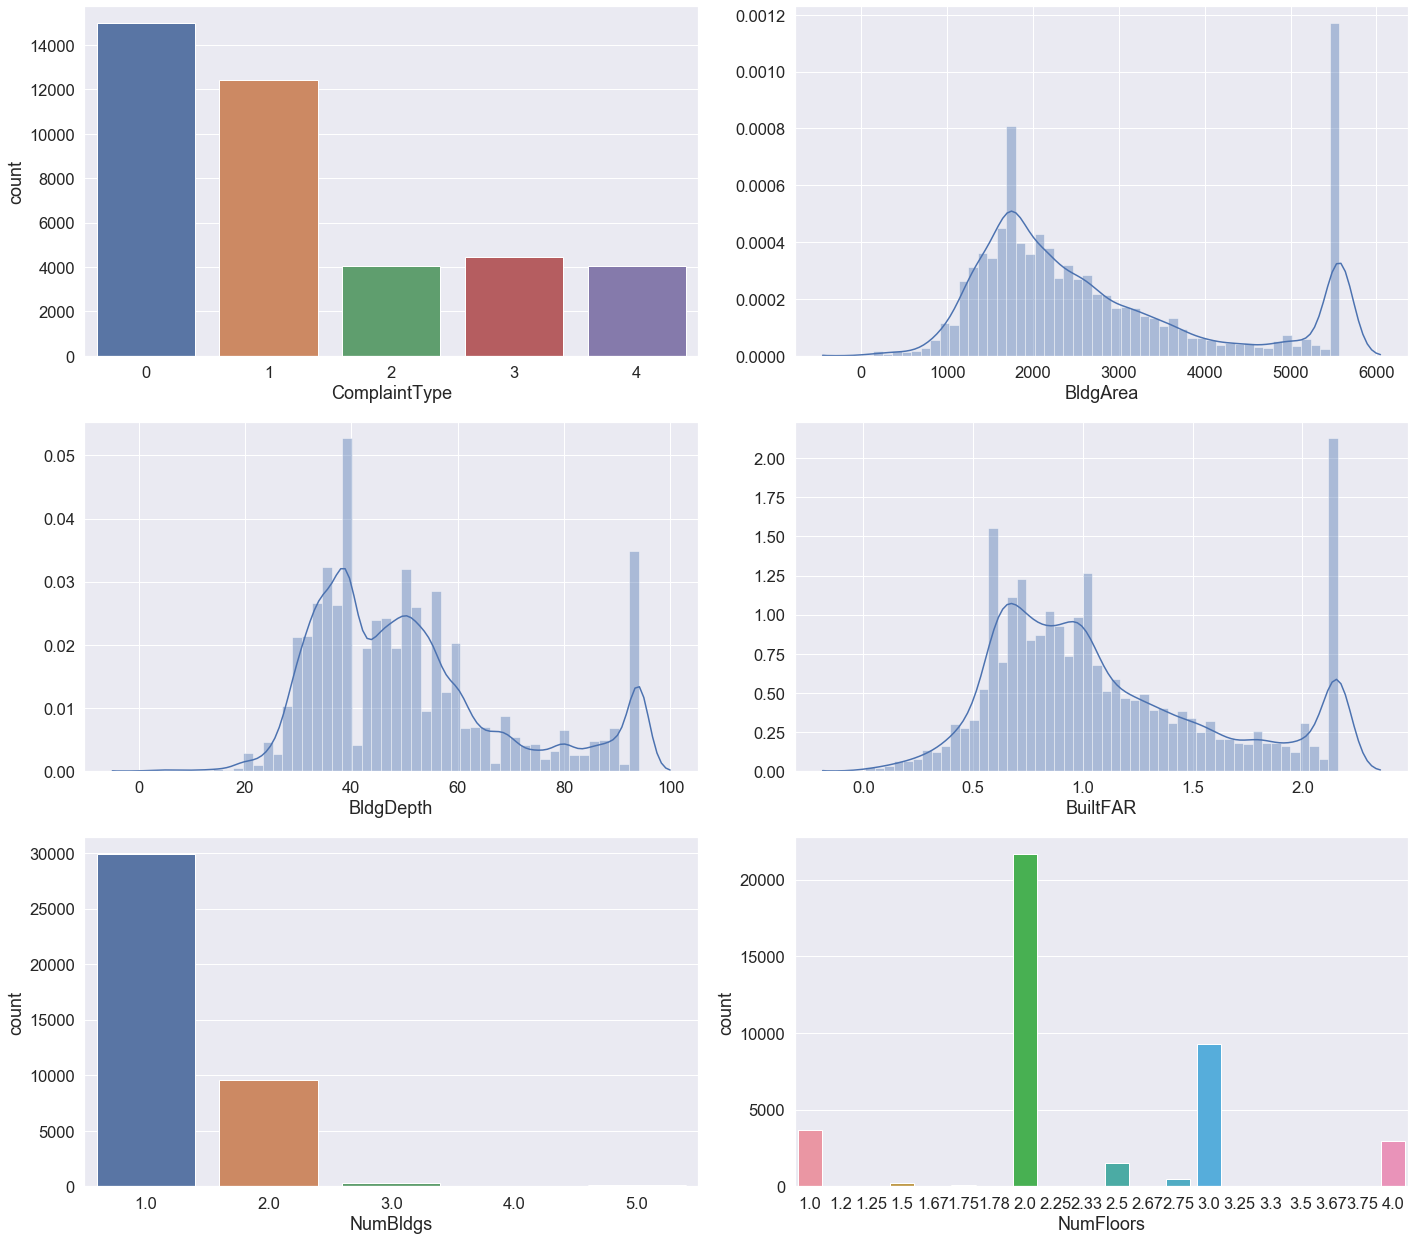

In [39]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.countplot(df.ComplaintType)
plt.subplot(7,2,2)
sns.distplot(df.BldgArea)
plt.subplot(7,2,3)
sns.distplot(df.BldgDepth)
plt.subplot(7,2,4)
sns.distplot(df.BuiltFAR)
plt.subplot(7,2,5)
sns.countplot(df.NumBldgs)
plt.subplot(7,2,6)
sns.countplot(df.NumFloors)
# plt.subplot(7,2,7)
# sns.countplot(df.Age)
# plt.subplot(7,2,8)
# sns.countplot(df.Period)
# plt.subplot(7,2,9)
# sns.countplot()
# plt.subplot(7,2,10)
# sns.countplot()
# plt.subplot(7,2,11)
# sns.countplot()
# plt.subplot(7,2,12)
# sns.countplot()
# plt.subplot(7,2,13)
# sns.countplot()
# plt.subplot(7,2,14)
# sns.countplot()

plt.tight_layout()
plt.show()

### Bivariate Data Exploration

In [40]:
df.corr()

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,ComplaintType
BldgArea,1.000000,0.775516,0.743115,-0.119437,0.363807,0.576252,0.082487,-0.079255,0.511859,-0.093604,0.697276,0.289227,-0.040791,-0.236825,-0.215959,-0.005736
BldgDepth,0.775516,1.000000,0.547713,-0.167842,0.322251,0.500711,0.177814,-0.071714,0.219595,-0.108578,0.465760,0.183930,-0.033384,-0.128686,-0.106639,-0.003546
BuiltFAR,0.743115,0.547713,1.000000,0.052582,0.291987,0.105983,-0.120026,-0.210152,0.693332,-0.061149,0.694566,0.419317,-0.137694,-0.198675,-0.195526,-0.002123
CommFAR,-0.119437,-0.167842,0.052582,1.000000,-0.025811,-0.208835,0.024397,0.035354,0.171096,0.124955,0.089643,0.317455,0.002835,0.089060,0.072207,-0.007143
FacilFAR,0.363807,0.322251,0.291987,-0.025811,1.000000,0.346090,-0.118325,-0.089604,0.128263,-0.124179,0.104007,0.340816,-0.107562,-0.072274,-0.056506,-0.001256
LotArea,0.576252,0.500711,0.105983,-0.208835,0.346090,1.000000,0.183297,0.079648,0.099516,-0.068324,0.216107,-0.004322,0.055057,-0.142017,-0.114819,-0.004573
LotDepth,0.082487,0.177814,-0.120026,0.024397,-0.118325,0.183297,1.000000,0.134593,0.013353,0.052042,0.074917,-0.101999,0.128093,0.064785,0.063731,0.000361
NumBldgs,-0.079255,-0.071714,-0.210152,0.035354,-0.089604,0.079648,0.134593,1.000000,-0.053500,0.023123,-0.049279,-0.076029,0.032755,0.164651,0.167106,-0.003310
NumFloors,0.511859,0.219595,0.693332,0.171096,0.128263,0.099516,0.013353,-0.053500,1.000000,0.043540,0.748074,0.344727,-0.047393,-0.181739,-0.193629,0.003191
OfficeArea,-0.093604,-0.108578,-0.061149,0.124955,-0.124179,-0.068324,0.052042,0.023123,0.043540,1.000000,0.042018,-0.044144,0.101858,0.053291,0.043237,-0.001043


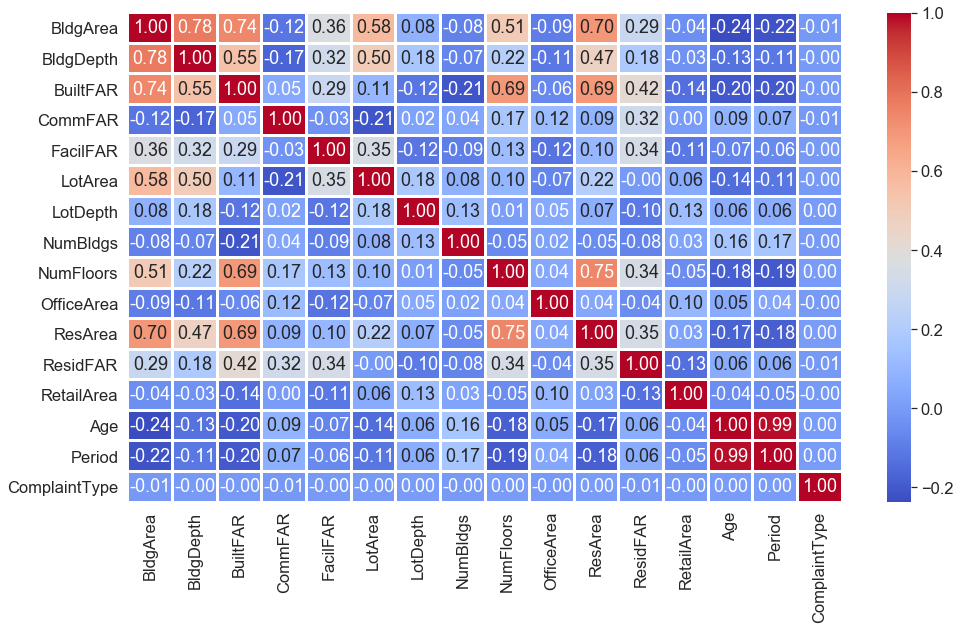

In [41]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

### Data Preprocessing

### Treat Duplicate Values

In [42]:
df.duplicated(keep='first').sum()

7634

In [43]:
df[df.duplicated(keep=False)]

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,ComplaintType
0,1760.0,39.0,0.61,2.0,5.0,9580.0,100.0,1.0,2.0,1680.0,1600.0,1.80,1500.0,71.0,85.0,0
1,1760.0,39.0,0.61,2.0,5.0,9580.0,100.0,1.0,2.0,1680.0,1600.0,1.80,1500.0,71.0,85.0,4
3,1760.0,39.0,0.61,2.0,5.0,9580.0,100.0,1.0,2.0,1680.0,1600.0,1.80,1500.0,71.0,85.0,1
4,1760.0,39.0,0.61,2.0,5.0,9580.0,100.0,1.0,2.0,1680.0,1600.0,1.80,1500.0,71.0,85.0,1
6,1760.0,39.0,0.61,2.0,5.0,9580.0,100.0,1.0,2.0,1680.0,1600.0,1.80,1500.0,71.0,85.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39964,2740.0,39.0,0.61,2.0,2.0,2850.0,100.0,1.0,2.0,1680.0,2740.0,1.25,1500.0,71.0,85.0,0
39965,2740.0,39.0,0.61,2.0,2.0,2850.0,100.0,1.0,2.0,1680.0,2740.0,1.25,1500.0,71.0,85.0,0
39971,2450.0,40.0,1.23,2.0,2.0,2000.0,100.0,1.0,2.0,1680.0,1650.0,1.25,1500.0,105.0,119.0,0
39973,2450.0,40.0,1.23,2.0,2.0,2000.0,100.0,1.0,2.0,1680.0,1650.0,1.25,1500.0,105.0,119.0,0


In [44]:
df.drop_duplicates(keep='first',ignore_index=True, inplace=True)

In [45]:
df

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,ComplaintType
0,1760.0,39.0,0.61,2.0,5.0,9580.0,100.00,1.0,2.0,1680.0,1600.0,1.80,1500.0,71.0,85.0,0
1,1760.0,39.0,0.61,2.0,5.0,9580.0,100.00,1.0,2.0,1680.0,1600.0,1.80,1500.0,71.0,85.0,4
2,5569.0,94.0,2.16,2.0,5.0,9580.0,100.00,1.0,4.0,1680.0,1600.0,1.80,1500.0,0.0,9.0,3
3,1760.0,39.0,0.61,2.0,5.0,9580.0,100.00,1.0,2.0,1680.0,1600.0,1.80,1500.0,71.0,85.0,1
4,1760.0,39.0,0.61,2.0,5.0,9580.0,100.00,1.0,2.0,1680.0,1600.0,1.80,1500.0,-5.0,9.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32361,2353.0,66.0,0.75,2.0,2.0,3141.0,100.00,2.0,2.0,1680.0,2353.0,1.25,1500.0,91.0,105.0,3
32362,1056.0,26.0,0.34,2.0,2.0,3131.0,100.00,2.0,2.0,1680.0,1056.0,1.25,1500.0,91.0,105.0,0
32363,1072.0,26.0,0.41,2.0,2.0,2628.0,97.33,2.0,2.0,1680.0,1072.0,1.25,1500.0,91.0,105.0,0
32364,1072.0,26.0,0.41,2.0,2.0,2596.0,97.33,2.0,2.0,1680.0,1072.0,1.25,1500.0,91.0,105.0,0


### HEAT/HOT WATER = 0; OTHERS = 1, PAINT/PLASTER = 2, PLUMBING = 3, UNSANITARY CONDITION = 4

### Train Test Split

In [46]:
X = df.iloc[:,0:15]
y = df.iloc[:,15]

### Treat Imbalance Data

In [47]:
y.value_counts()

0    11520
1     9789
3     3893
2     3612
4     3552
Name: ComplaintType, dtype: int64

In [48]:
ros = RandomOverSampler(sampling_strategy='all',random_state=0)

In [49]:
new_X, new_y = ros.fit_resample(X, y)

In [50]:
new_y.value_counts()

4    11520
3    11520
2    11520
1    11520
0    11520
Name: ComplaintType, dtype: int64

In [51]:
new_X

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period
0,1760.0,39.0,0.61,2.0,5.0,9580.0,100.00,1.0,2.0,1680.0,1600.0,1.80,1500.0,71.0,85.0
1,1760.0,39.0,0.61,2.0,5.0,9580.0,100.00,1.0,2.0,1680.0,1600.0,1.80,1500.0,71.0,85.0
2,5569.0,94.0,2.16,2.0,5.0,9580.0,100.00,1.0,4.0,1680.0,1600.0,1.80,1500.0,0.0,9.0
3,1760.0,39.0,0.61,2.0,5.0,9580.0,100.00,1.0,2.0,1680.0,1600.0,1.80,1500.0,71.0,85.0
4,1760.0,39.0,0.61,2.0,5.0,9580.0,100.00,1.0,2.0,1680.0,1600.0,1.80,1500.0,-5.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57595,1864.0,39.0,0.50,2.0,2.0,3752.0,100.00,2.0,2.0,1680.0,1864.0,1.35,1500.0,86.0,100.0
57596,1200.0,39.0,0.58,2.0,3.0,2070.0,60.33,1.0,2.0,1680.0,1600.0,1.80,1500.0,46.0,60.0
57597,5569.0,65.0,1.19,1.0,2.4,9580.0,65.00,1.0,1.0,1680.0,1600.0,0.60,1500.0,40.0,54.0
57598,2840.0,65.0,1.14,2.0,2.0,2500.0,100.00,1.0,2.0,1680.0,2840.0,1.80,1500.0,75.0,89.0


In [52]:
new_X.values, new_y.values

(array([[1.760e+03, 3.900e+01, 6.100e-01, ..., 1.500e+03, 7.100e+01,
         8.500e+01],
        [1.760e+03, 3.900e+01, 6.100e-01, ..., 1.500e+03, 7.100e+01,
         8.500e+01],
        [5.569e+03, 9.400e+01, 2.160e+00, ..., 1.500e+03, 0.000e+00,
         9.000e+00],
        ...,
        [5.569e+03, 6.500e+01, 1.190e+00, ..., 1.500e+03, 4.000e+01,
         5.400e+01],
        [2.840e+03, 6.500e+01, 1.140e+00, ..., 1.500e+03, 7.500e+01,
         8.900e+01],
        [5.569e+03, 6.200e+01, 2.160e+00, ..., 1.500e+03, 7.600e+01,
         9.000e+01]]),
 array([0, 4, 3, ..., 4, 4, 4], dtype=int64))

In [53]:
X_train, X_test, y_train, y_test = train_test_split(new_X.values, new_y.values, test_size=0.2, random_state=0)

In [54]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((46080, 15), (11520, 15), (46080,), (11520,))

### Feature Scaling

In [55]:
X_train

array([[5.569e+03, 9.400e+01, 2.160e+00, ..., 1.500e+03, 8.000e+01,
        9.400e+01],
       [2.012e+03, 3.250e+01, 1.010e+00, ..., 1.500e+03, 8.600e+01,
        1.000e+02],
       [2.850e+03, 4.500e+01, 1.140e+00, ..., 1.500e+03, 6.600e+01,
        8.000e+01],
       ...,
       [2.160e+03, 3.600e+01, 1.080e+00, ..., 1.500e+03, 6.600e+01,
        8.000e+01],
       [2.800e+03, 5.000e+01, 1.370e+00, ..., 1.500e+03, 4.100e+01,
        5.500e+01],
       [2.082e+03, 4.700e+01, 1.220e+00, ..., 1.500e+03, 7.600e+01,
        9.000e+01]])

In [56]:
scaler = StandardScaler()

In [57]:
X_train_scaled = scaler.fit_transform(X_train)

In [58]:
X_test_scaled = scaler.transform(X_test)

In [59]:
X_train_scaled

array([[ 1.88227783,  2.22561399,  1.95972366, ...,  0.18356506,
         0.5635933 ,  0.54373973],
       [-0.57299286, -1.00549385, -0.2101967 , ...,  0.18356506,
         0.80360199,  0.78526206],
       [ 0.00544876, -0.34876461,  0.03509864, ...,  0.18356506,
         0.00357305, -0.01981238],
       ...,
       [-0.47083372, -0.82160966, -0.07811459, ...,  0.18356506,
         0.00357305, -0.01981238],
       [-0.02906446, -0.08607292,  0.46908271, ...,  0.18356506,
        -0.99646313, -1.02615543],
       [-0.52467435, -0.24368793,  0.18604962, ...,  0.18356506,
         0.40358752,  0.38272484]])

In [60]:
X_test_scaled

array([[ 0.05376727, -1.32072388, -0.15359009, ...,  0.18356506,
        -1.19647037, -1.22742404],
       [-0.55366545,  0.22915712,  0.09170526, ...,  0.18356506,
         0.40358752,  0.38272484],
       [-0.52605488, -0.82160966, -0.54983641, ...,  0.18356506,
         0.28358318,  0.18145623],
       ...,
       [-0.11534752, -0.55891797,  0.46908271, ...,  0.18356506,
        -0.99646313, -1.02615543],
       [-0.74003686, -0.50637963, -0.79513176, ...,  0.18356506,
         1.56362948,  1.55008278],
       [ 0.73022644,  0.0715421 ,  1.95972366, ...,  0.18356506,
         1.20361646,  1.18779929]])

In [61]:
y_train

array([1, 4, 4, ..., 3, 3, 0], dtype=int64)

In [62]:
y_test

array([1, 3, 1, ..., 2, 1, 0], dtype=int64)

### Model Training

### Using XGBoost (Scikit-Learn)

In [63]:
xgbmodel = XGBClassifier(random_state=0, n_estimators=300, objective='multi:softmax')

In [64]:
xgbmodel.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='merror',early_stopping_rounds=10)

[0]	validation_0-merror:0.782205
Will train until validation_0-merror hasn't improved in 10 rounds.
[1]	validation_0-merror:0.779601
[2]	validation_0-merror:0.776649
[3]	validation_0-merror:0.773872
[4]	validation_0-merror:0.774653
[5]	validation_0-merror:0.77526
[6]	validation_0-merror:0.777083
[7]	validation_0-merror:0.778472
[8]	validation_0-merror:0.775608
[9]	validation_0-merror:0.77691
[10]	validation_0-merror:0.775087
[11]	validation_0-merror:0.774045
[12]	validation_0-merror:0.774913
[13]	validation_0-merror:0.774913
Stopping. Best iteration:
[3]	validation_0-merror:0.773872



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [65]:
y_pred = xgbmodel.predict(X_test_scaled)

In [66]:
y_pred

array([1, 3, 4, ..., 3, 1, 0], dtype=int64)

### Model Evaluation

In [67]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[644, 324, 509, 363, 480],
       [598, 347, 541, 366, 447],
       [517, 319, 660, 344, 482],
       [545, 291, 540, 468, 454],
       [549, 295, 546, 405, 486]], dtype=int64)

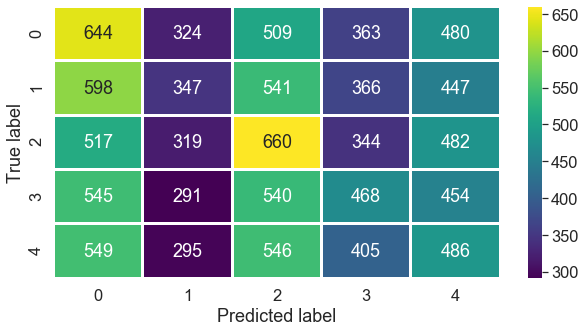

In [68]:
fig , ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True,fmt='.4g',linewidths=2, cmap='viridis')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [69]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.23      0.28      0.25      2320
           1       0.22      0.15      0.18      2299
           2       0.24      0.28      0.26      2322
           3       0.24      0.20      0.22      2298
           4       0.21      0.21      0.21      2281

    accuracy                           0.23     11520
   macro avg       0.23      0.23      0.22     11520
weighted avg       0.23      0.23      0.22     11520



### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

In [70]:
X.columns

Index(['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'LotArea',
       'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea',
       'ResidFAR', 'RetailArea', 'Age', 'Period'],
      dtype='object')

In [71]:
xgbmodel.get_booster().feature_names = ['BldgArea', 'BldgDepth', 'BuiltFAR', 'CommFAR', 'FacilFAR', 'LotArea',
       'LotDepth', 'NumBldgs', 'NumFloors', 'OfficeArea', 'ResArea','ResidFAR', 'RetailArea', 'Age', 'Period']

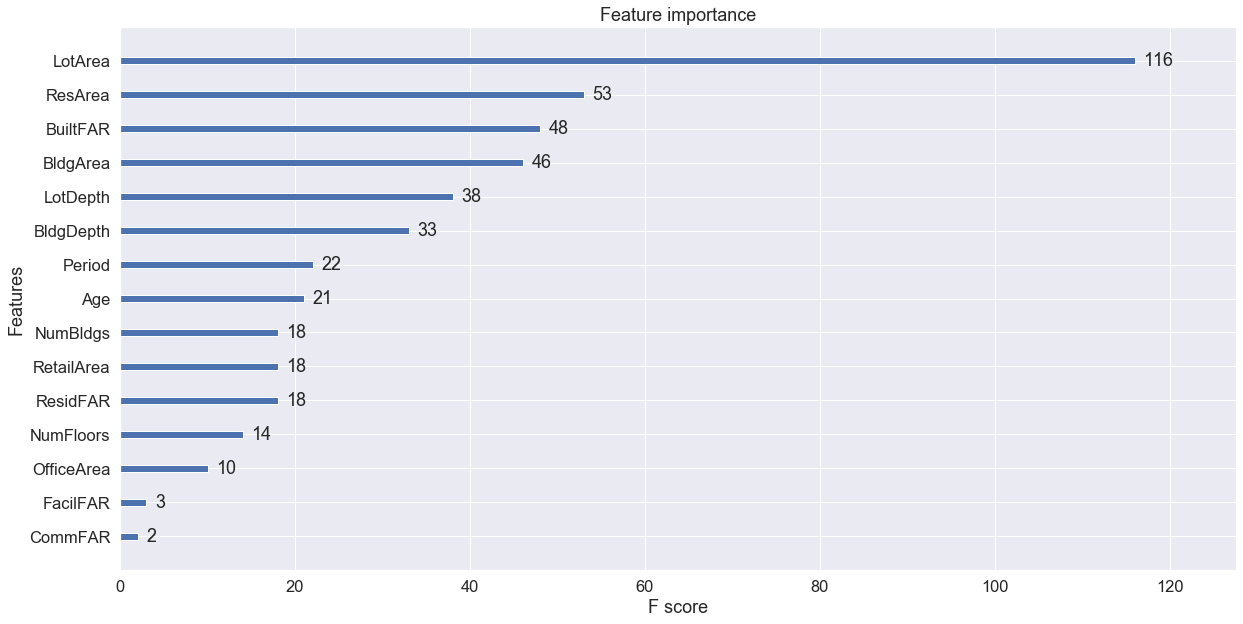

In [72]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbmodel.get_booster(),ax=ax)
plt.show()

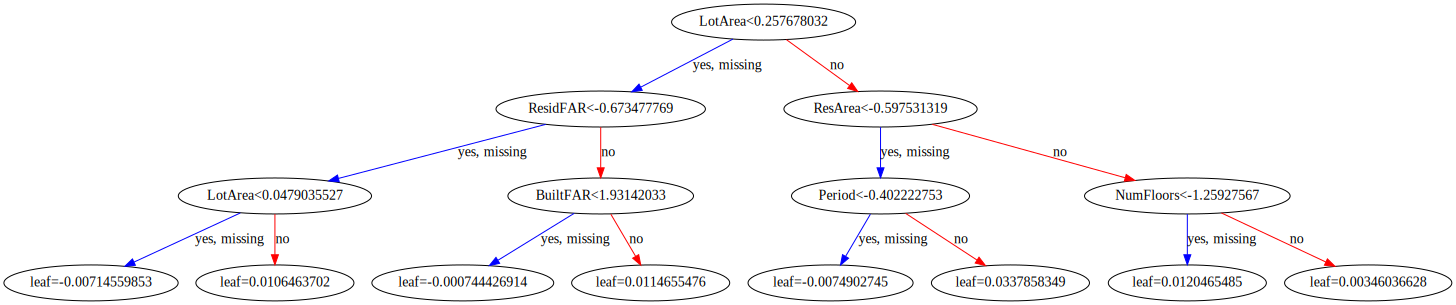

In [74]:
xgb.to_graphviz(xgbmodel,num_trees=10)

### Cross-Validation

In [75]:
cv = cross_val_score(xgbmodel,X_train_scaled,y_train,cv=5,verbose=1,scoring='accuracy')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.4min finished


In [76]:
cv.mean()

0.2841145833333333

### Using XGBoost (API)

{'subsample': 0.7,
 'n_estimators': 700,
 'min_child_weight': 3,
 'max_depth': 5,
 'learning rate': 0.29,
 'gamma': 0,
 'colsample_bytree': 0.6}

In [77]:
dtrain = xgb.DMatrix(data=X_train_scaled,label=y_train)
dtest = xgb.DMatrix(data=X_test_scaled,label=y_test)

In [78]:
params = {'n_estimators': 700,
          'learning_rate': 0.29,
          'max_depth': 5,
          'min_child_weight': 3,
          'objective': 'multi:softmax',
          'num_class': 5 ,
          'seed': 0,
          'colsample_bytree': 0.6,
          'subsample' : 0.7,
          'gamma' : 0,
          'eval_metric':'merror'}

In [79]:
xgbmodel = xgb.train(params=params,dtrain=dtrain,num_boost_round=500,evals=[(dtest,"Test")],
                     early_stopping_rounds=10)

[0]	Test-merror:0.780642
Will train until Test-merror hasn't improved in 10 rounds.
[1]	Test-merror:0.767187
[2]	Test-merror:0.767101
[3]	Test-merror:0.759896
[4]	Test-merror:0.752344
[5]	Test-merror:0.751562
[6]	Test-merror:0.749913
[7]	Test-merror:0.747049
[8]	Test-merror:0.748177
[9]	Test-merror:0.745052
[10]	Test-merror:0.741753
[11]	Test-merror:0.738889
[12]	Test-merror:0.734201
[13]	Test-merror:0.731858
[14]	Test-merror:0.733854
[15]	Test-merror:0.733333
[16]	Test-merror:0.72908
[17]	Test-merror:0.726042
[18]	Test-merror:0.723003
[19]	Test-merror:0.721354
[20]	Test-merror:0.719271
[21]	Test-merror:0.721267
[22]	Test-merror:0.720139
[23]	Test-merror:0.719531
[24]	Test-merror:0.718837
[25]	Test-merror:0.715538
[26]	Test-merror:0.714583
[27]	Test-merror:0.711285
[28]	Test-merror:0.708507
[29]	Test-merror:0.707465
[30]	Test-merror:0.705122
[31]	Test-merror:0.70434
[32]	Test-merror:0.703385
[33]	Test-merror:0.702691
[34]	Test-merror:0.703125
[35]	Test-merror:0.700608
[36]	Test-merror:

In [80]:
y_pred = xgbmodel.predict(dtest)

In [81]:
y_pred

array([1., 3., 4., ..., 2., 1., 4.], dtype=float32)

### Cross-Validation (API)

In [82]:
 cv = xgb.cv(params=params,
             dtrain=dtrain,
             num_boost_round=200,
             nfold=5,
             stratified=False,
             folds=None,
             metrics=('merror'),
             obj=None,
             feval=None,
             maximize=False,
             early_stopping_rounds=10,
             fpreproc=None,
             as_pandas=True,
             verbose_eval=None,
             show_stdv=True,
             seed=0,
             callbacks=None,
             shuffle=True,)

In [83]:
cv

,train-merror-mean,train-merror-std,test-merror-mean,test-merror-std
0,0.765853,0.005034,0.782595,0.002662
1,0.749115,0.005685,0.774978,0.002900
2,0.734473,0.003065,0.766667,0.001955
3,0.723166,0.005504,0.765799,0.005098
4,0.716775,0.005676,0.762673,0.005670
...,...,...,...,...
195,0.418582,0.002185,0.606250,0.003185
196,0.418273,0.002119,0.606337,0.002221
197,0.417703,0.001926,0.606163,0.002845
198,0.416417,0.002385,0.605317,0.003951


In [84]:
cv['test-merror-mean'].min()

0.6050563999999999

### Model Evaluation

In [85]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[ 478,  503,  458,  453,  428],
       [ 477,  592,  402,  385,  443],
       [ 263,  247, 1160,  309,  343],
       [ 310,  228,  325, 1111,  324],
       [ 281,  229,  281,  311, 1179]], dtype=int64)

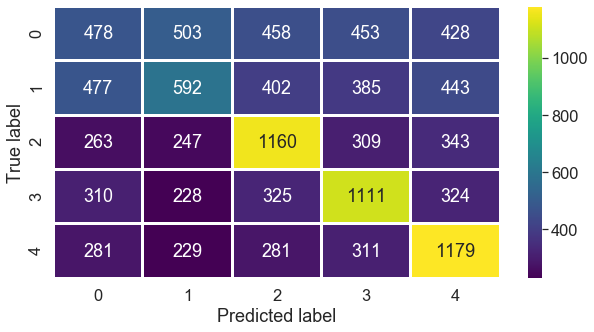

In [86]:
fig , ax = plt.subplots(figsize=(10,5))
sns.heatmap(cm, annot=True,fmt='.4g',linewidths=2, cmap='viridis')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [87]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.26      0.21      0.23      2320
           1       0.33      0.26      0.29      2299
           2       0.44      0.50      0.47      2322
           3       0.43      0.48      0.46      2298
           4       0.43      0.52      0.47      2281

    accuracy                           0.39     11520
   macro avg       0.38      0.39      0.38     11520
weighted avg       0.38      0.39      0.38     11520



### Model Tuning

### Using RandomSearchCV

In [3]:
df = pd.read_csv("queensclasstrain.csv", nrows=2000)

In [4]:
df.duplicated(keep='first').sum()

302

In [5]:
df[df.duplicated(keep=False)]

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,ComplaintType
0,1760.0,39.0,0.61,2.0,5.0,9580.0,100.0,1.0,2.0,1680.0,1600.0,1.80,1500.0,71.0,85.0,0
1,1760.0,39.0,0.61,2.0,5.0,9580.0,100.0,1.0,2.0,1680.0,1600.0,1.80,1500.0,71.0,85.0,4
3,1760.0,39.0,0.61,2.0,5.0,9580.0,100.0,1.0,2.0,1680.0,1600.0,1.80,1500.0,71.0,85.0,1
4,1760.0,39.0,0.61,2.0,5.0,9580.0,100.0,1.0,2.0,1680.0,1600.0,1.80,1500.0,71.0,85.0,1
6,1760.0,39.0,0.61,2.0,5.0,9580.0,100.0,1.0,2.0,1680.0,1600.0,1.80,1500.0,71.0,85.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1955,2268.0,63.0,1.26,2.0,2.0,1800.0,100.0,1.0,2.0,1680.0,1134.0,1.35,1134.0,76.0,90.0,0
1968,5569.0,65.0,2.16,2.0,4.0,2500.0,100.0,1.0,3.0,1680.0,4584.0,1.80,1500.0,35.0,49.0,0
1969,5569.0,65.0,2.16,2.0,4.0,2500.0,100.0,1.0,3.0,1680.0,4584.0,1.80,1500.0,35.0,49.0,0
1970,5569.0,65.0,2.16,2.0,4.0,2500.0,100.0,1.0,3.0,1680.0,4584.0,1.80,1500.0,35.0,49.0,0


In [6]:
df.drop_duplicates(keep='first',ignore_index=True, inplace=True)

In [7]:
df

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period,ComplaintType
0,1760.0,39.0,0.61,2.0,5.0,9580.0,100.00,1.0,2.0,1680.0,1600.0,1.8,1500.0,71.0,85.0,0
1,1760.0,39.0,0.61,2.0,5.0,9580.0,100.00,1.0,2.0,1680.0,1600.0,1.8,1500.0,71.0,85.0,4
2,5569.0,94.0,2.16,2.0,5.0,9580.0,100.00,1.0,4.0,1680.0,1600.0,1.8,1500.0,0.0,9.0,3
3,1760.0,39.0,0.61,2.0,5.0,9580.0,100.00,1.0,2.0,1680.0,1600.0,1.8,1500.0,71.0,85.0,1
4,1760.0,39.0,0.61,2.0,5.0,9580.0,100.00,1.0,2.0,1680.0,1600.0,1.8,1500.0,-5.0,9.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1693,5569.0,71.0,2.16,2.0,4.0,7271.0,71.54,1.0,4.0,1680.0,4584.0,1.8,1500.0,-8.0,6.0,0
1694,2365.0,50.0,1.45,2.0,4.0,1633.0,71.00,1.0,2.0,1680.0,1720.0,1.8,1500.0,76.0,90.0,1
1695,5569.0,87.0,2.16,2.0,4.0,3600.0,95.00,1.0,4.0,1680.0,4584.0,1.8,1500.0,78.0,92.0,1
1696,5569.0,87.0,2.16,2.0,4.0,3700.0,95.00,1.0,4.0,1680.0,4584.0,1.8,1500.0,78.0,92.0,4


### HEAT/HOT WATER = 0; OTHERS = 1, PAINT/PLASTER = 2, PLUMBING = 3, UNSANITARY CONDITION = 4

### Train Test Split

In [8]:
X = df.iloc[:,0:15]
y = df.iloc[:,15]

In [9]:
y.value_counts()

0    611
1    508
4    196
3    196
2    187
Name: ComplaintType, dtype: int64

In [10]:
ros = RandomOverSampler(sampling_strategy='all',random_state=0)

In [11]:
new_X, new_y = ros.fit_resample(X, y)

In [12]:
new_y.value_counts()

3    611
1    611
4    611
2    611
0    611
Name: ComplaintType, dtype: int64

In [13]:
new_X

,BldgArea,BldgDepth,BuiltFAR,CommFAR,FacilFAR,LotArea,LotDepth,NumBldgs,NumFloors,OfficeArea,ResArea,ResidFAR,RetailArea,Age,Period
0,1760.0,39.0,0.61,2.0,5.0,9580.0,100.00,1.0,2.0,1680.0,1600.0,1.8,1500.0,71.0,85.0
1,1760.0,39.0,0.61,2.0,5.0,9580.0,100.00,1.0,2.0,1680.0,1600.0,1.8,1500.0,71.0,85.0
2,5569.0,94.0,2.16,2.0,5.0,9580.0,100.00,1.0,4.0,1680.0,1600.0,1.8,1500.0,0.0,9.0
3,1760.0,39.0,0.61,2.0,5.0,9580.0,100.00,1.0,2.0,1680.0,1600.0,1.8,1500.0,71.0,85.0
4,1760.0,39.0,0.61,2.0,5.0,9580.0,100.00,1.0,2.0,1680.0,1600.0,1.8,1500.0,-5.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3050,2310.0,40.0,2.16,2.0,2.0,1068.0,53.42,1.0,2.0,1680.0,1540.0,1.8,1500.0,80.0,120.0
3051,1760.0,39.0,0.61,2.0,5.0,9580.0,100.00,1.0,2.0,1680.0,1600.0,0.6,1500.0,71.0,85.0
3052,2500.0,33.0,1.00,2.0,3.0,2500.0,100.00,1.0,3.0,1680.0,2500.0,1.8,1500.0,110.0,139.0
3053,487.0,25.0,0.68,1.0,2.4,720.0,35.00,1.0,1.0,1680.0,1600.0,0.6,1500.0,56.0,70.0


In [14]:
new_X.values, new_y.values

(array([[1.760e+03, 3.900e+01, 6.100e-01, ..., 1.500e+03, 7.100e+01,
         8.500e+01],
        [1.760e+03, 3.900e+01, 6.100e-01, ..., 1.500e+03, 7.100e+01,
         8.500e+01],
        [5.569e+03, 9.400e+01, 2.160e+00, ..., 1.500e+03, 0.000e+00,
         9.000e+00],
        ...,
        [2.500e+03, 3.300e+01, 1.000e+00, ..., 1.500e+03, 1.100e+02,
         1.390e+02],
        [4.870e+02, 2.500e+01, 6.800e-01, ..., 1.500e+03, 5.600e+01,
         7.000e+01],
        [1.568e+03, 2.800e+01, 7.300e-01, ..., 1.500e+03, 4.200e+01,
         7.900e+01]]),
 array([0, 4, 3, ..., 4, 4, 4], dtype=int64))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(new_X.values, new_y.values, test_size=0.2, random_state=0)

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2444, 15), (611, 15), (2444,), (611,))

In [17]:
X_train

array([[2.500e+03, 5.000e+01, 1.000e+00, ..., 1.500e+03, 7.000e+01,
        8.900e+01],
       [1.568e+03, 2.800e+01, 6.600e-01, ..., 1.500e+03, 8.100e+01,
        9.500e+01],
       [5.569e+03, 5.500e+01, 2.160e+00, ..., 1.500e+03, 7.500e+01,
        8.900e+01],
       ...,
       [2.584e+03, 6.800e+01, 1.360e+00, ..., 1.292e+03, 7.600e+01,
        9.000e+01],
       [5.569e+03, 9.400e+01, 1.000e+00, ..., 1.500e+03, 7.500e+01,
        8.900e+01],
       [1.760e+03, 3.900e+01, 6.100e-01, ..., 1.500e+03, 7.100e+01,
        8.500e+01]])

In [18]:
scaler = StandardScaler()

In [19]:
X_train_scaled = scaler.fit_transform(X_train)

In [20]:
X_test_scaled = scaler.transform(X_test)

In [21]:
X_train_scaled

array([[-0.39813891, -0.14654538, -0.3525002 , ...,  0.23183669,
        -0.04447212,  0.0429465 ],
       [-0.93990342, -1.07709769, -0.90472969, ...,  0.23183669,
         0.38436165,  0.2618438 ],
       [ 1.38584744,  0.06494379,  1.53157688, ...,  0.23183669,
         0.15045232,  0.0429465 ],
       ...,
       [-0.34931035,  0.61481561,  0.23221338, ..., -1.52921176,
         0.18943721,  0.07942939],
       [ 1.38584744,  1.71455926, -0.3525002 , ...,  0.23183669,
         0.15045232,  0.0429465 ],
       [-0.82829528, -0.61182153, -0.98593991, ...,  0.23183669,
        -0.00548723, -0.10298503]])

In [22]:
X_test_scaled

array([[ 1.38584744,  1.71455926, -0.04390137, ...,  0.23183669,
         0.15045232,  0.0429465 ],
       [-0.61205451, -0.52722587, -1.06715013, ...,  0.23183669,
         0.38436165,  0.2618438 ],
       [-0.6887851 ,  0.10724162, -0.27128998, ...,  0.23183669,
         0.18943721,  0.07942939],
       ...,
       [-1.20032241, -1.07709769, -1.16460239, ...,  0.23183669,
         0.57928609,  0.44425822],
       [-1.29797953, -1.07709769, -0.83976152, ...,  0.23183669,
         0.38436165,  0.2618438 ],
       [-1.20032241, -1.07709769, -1.06715013, ...,  0.23183669,
         0.57928609,  0.44425822]])

In [23]:
y_train

array([1, 2, 0, ..., 1, 3, 4], dtype=int64)

In [24]:
y_test

array([0, 4, 1, 3, 0, 1, 3, 2, 1, 3, 1, 4, 2, 2, 3, 1, 4, 2, 2, 4, 4, 2,
       2, 0, 2, 0, 1, 2, 0, 3, 3, 4, 3, 3, 1, 3, 0, 2, 1, 2, 2, 3, 1, 3,
       3, 1, 4, 2, 1, 4, 3, 2, 0, 0, 3, 4, 0, 0, 0, 1, 4, 2, 3, 1, 2, 4,
       1, 2, 1, 1, 3, 2, 0, 4, 0, 3, 4, 2, 0, 1, 1, 3, 2, 2, 0, 3, 0, 3,
       4, 2, 4, 4, 0, 0, 1, 1, 0, 3, 0, 1, 0, 1, 4, 2, 2, 4, 3, 2, 3, 3,
       4, 3, 0, 2, 3, 3, 2, 3, 2, 3, 2, 1, 4, 1, 2, 4, 0, 1, 4, 4, 1, 2,
       2, 1, 4, 2, 0, 0, 0, 1, 1, 1, 4, 0, 2, 1, 0, 4, 1, 1, 3, 2, 4, 3,
       4, 0, 0, 3, 3, 3, 4, 0, 2, 2, 0, 2, 3, 3, 2, 4, 3, 4, 4, 2, 1, 4,
       4, 1, 0, 2, 4, 1, 4, 0, 0, 4, 4, 1, 1, 0, 1, 0, 3, 0, 4, 3, 3, 3,
       3, 4, 4, 1, 2, 3, 2, 1, 4, 1, 4, 0, 3, 4, 2, 0, 1, 3, 1, 4, 1, 3,
       4, 2, 0, 4, 0, 4, 4, 0, 3, 2, 0, 2, 2, 0, 4, 3, 4, 0, 0, 2, 1, 0,
       2, 2, 1, 3, 0, 4, 0, 0, 1, 3, 4, 1, 1, 1, 4, 2, 1, 2, 1, 0, 3, 1,
       3, 1, 1, 1, 2, 4, 4, 0, 2, 3, 4, 1, 0, 2, 1, 2, 4, 0, 2, 2, 3, 1,
       2, 4, 1, 0, 4, 0, 1, 1, 3, 4, 2, 0, 4, 1, 3,

In [25]:
model = XGBClassifier(random_state=0, n_estimators=100, objective='multi:softmax')

In [26]:
parameters = {'max_depth': np.arange(3,10,1),
              'learning rate': np.arange(0.05,0.3,0.03),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,50,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1)
             }

In [27]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 50, 
                           n_jobs=-1, scoring='accuracy')

In [28]:
randm.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='multi:softmax',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, scal...
       34, 36, 38, 40, 42, 44, 46, 48]),
                                        'learning rate': array([0.05, 0.08, 0.11, 0.14, 0.17, 0.2 , 0.23, 0.26, 0.29]),
                

In [29]:
randm.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0,
              learning rate=0.29, learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=3, missing=None, n_estimators=700,
              n_jobs=1, nthread=None, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.7, verbosity=1)

In [30]:
randm.best_score_

0.6014792651446579

In [31]:
randm.best_params_

{'subsample': 0.7,
 'n_estimators': 700,
 'min_child_weight': 3,
 'max_depth': 5,
 'learning rate': 0.29,
 'gamma': 0,
 'colsample_bytree': 0.6}

{'subsample': 0.7,
 'n_estimators': 700,
 'min_child_weight': 3,
 'max_depth': 5,
 'learning rate': 0.29,
 'gamma': 0,
 'colsample_bytree': 0.6}

### Save the Model

In [88]:
filename = 'modelqueens.sav'
dump(xgbmodel,open(filename,'wb'))